# A/B Testing

In [46]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## 1. Designing our experiment

#### Formulating a hypothesis:

I'll choose a two-tailed test:
$$H_0: p = p_0$$
$$H_a: p \ne p_0$$
where $p$ and $p_0$ stand for the conversion rate of the new and old design, respectively. I'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$

=> All this really means is that whatever conversion rate we observe for our new design in our test, we want to be 95% confident it is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis $H_0$. 

#### Choosing the variables:

For my test I'll need **two groups**:
* A `control` group - They'll be shown the old design
* A `treatment` (or experimental) group - They'll be shown the new design

For my *Dependent Variable* (i.e. what we are trying to measure), I'm interested in capturing the `conversion rate`. A way I can code this is by  each user session with a binary variable:
* `0` - The user did not buy the product during this user session
* `1` - The user bought the product during this user session


#### Choosing the sample size: 

The sample size I need is estimated through something called Power analysis, and it depends on a few factors:
* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention statistical power</a>)
* **Alpha value** ($\alpha$) - The critical value we can set earlier to 0.05
* **Effect size** - How big of a difference we expect there to be between the conversion rates

In [4]:
# Calculate the effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )
# Rounding up to next whole number
required_n = ceil(required_n) 
required_n

4720

=> We'd need at least **4720 observations** for each group.

## 2. Collecting and preparing the data

In [5]:
# import dataset from csv file
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


* `user_id` - The user ID of each session
* `timestamp` - Timestamp for the session
* `group` - Which group the user was assigned to for that session {`control`, `treatment`}
* `landing_page` - Which design each user saw on that session {`old_page`, `new_page`}
* `converted` - Whether the session ended in a conversion or not (binary, `0`=not converted, `1`=converted)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
# Check whether users have been sampled multiple times or not
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
multi_users

3894

In [13]:
# Remove them from the DataFrame to avoid sampling the same users twice.
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]

#### Sampling

In [17]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample,treatment_sample], axis = 0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [18]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

## 3. Visualize the result

In [22]:
conversion_rates = ab_test.groupby('group')['converted']
#standard deviation of the proportion
std_p = lambda x: np.std(x,ddof=0)
#standard error of the proportion 
se_p = lambda x: stats.sem(x,ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation','std_error']
conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.123305,0.328787,0.004786
treatment,0.125636,0.331438,0.004824


=> it does look like our two designs performed very similarly, with our *new design performing slightly better*, approx. 12.3% vs. 12.6% conversion rate.

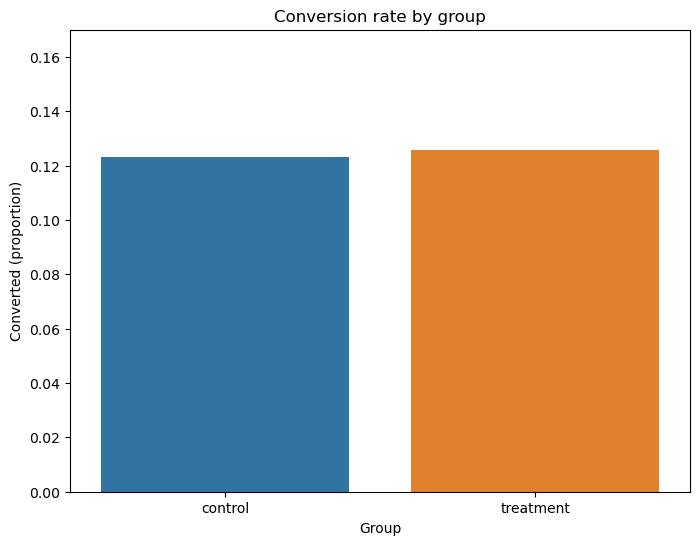

In [32]:
#plot the data
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'],y=ab_test['converted'],ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

=> the treatment group's value is higher

## 4. Testing the hypothesis

In [38]:
control_results = ab_test[ab_test['group']=='control']['converted']
treatment_results = ab_test[ab_test['group']=='treatment']['converted']

In [45]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


## 5. Drawing conclusions

Since my $p$-value=0.732 > $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different (let alone better) than our old one

At the confidence interval for the `treatment` group ([0.116, 0.135], i.e. 11.6-13.5%) I notice that:
- It includes our baseline value of 13% conversion rate
- It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for.